## Ordinary Differential Equations (ODEs)

### Generic f function, and using scipy.integrate.odeint

In [2]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')
# Timer to measure the performance of methods
from time import time
from scipy.integrate import odeint

Runge-Kutta, steps:  130 time:  0.0749669075012207
scipy.integrate.odeint, steps:  374 time:  0.03891801834106445


/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


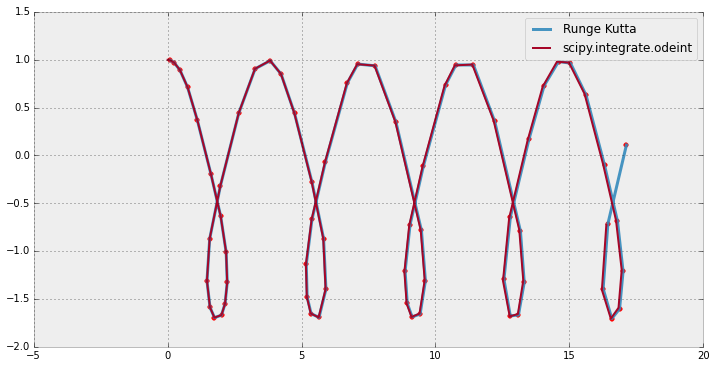

In [16]:
## Example problem: Circular orbit in magnetic field

def B(t, x):
    return x[1]**2*np.array([0., 0., 1.])
    #return np.array([0., 0., 1.])

# Define one function, to return the two derivatives
def f(Y, t):
    q = 1
    m = 1
    y, z = Y
    dy = z
    dz = q*np.cross(z, B(t, y))/m
    return np.array([dy, dz])

def rungeKutta(h, t, Y, f):
    k1 = f(Y,          t)
    k2 = f(Y + h*k1/2, t + h/2)
    k3 = f(Y + h*k2/2, t + h/2)
    k4 = f(Y + h*k3,   t + h)
    return Y + h*(k1 + 2*k2 + 2*k3 + k4)/6

def stepper(h, t, Y, f, integrator):
    # Step once, with stepsize h
    Y1 = integrator(h, t, Y, f)
    # Step twice, with stepsize h/2
    Y2 = integrator(h/2, t, Y, f)
    Y2 = integrator(h/2, t, Y2, f)
    # calculate error
    
    err = np.linalg.norm(Y2[0,:]-Y1[0,:])/np.linalg.norm(Y2[0,:])
    # Return x2, v2, which are presumable more accurate
    return Y2, err

def variableIntegrate(Tmax, h0, tol, integrator):
    T  = []
    X  = []
    V  = []
    # Initial values
    x  = np.array([0., 1., 0.])
    v  = np.array([1., 0., 0.])
    Y  = np.array([x, v])
    # Mapping to new variables, y and z:
    # y = x
    # z = v
    
    # Start at time 0, with initial guess of stepsize
    t = 0
    h = h0
    while t < Tmax:
        T.append(t)
        flag = True
        while flag:
            Y1, err = stepper(h, t, Y, f, integrator)
            if err > tol:
                h = h/2
            else:
                t += h
                h = 1.5*h
                Y = Y1
                flag = False
        X.append(Y[0])
        V.append(Y[1])
    T = np.array(T)
    X = np.array(X)
    V = np.array(V)
    return T, X, V
    
Tmax = 12*np.pi
h0   = 1e-1
tol  = 1e-3

# Figure parameters
plt.figure(figsize = (12,6))
linewidth = 3
alpha = 0.9

tic = time()
Tr, Xr, Vr = variableIntegrate(Tmax, h0, tol, rungeKutta)
toc = time()
print('Runge-Kutta, steps: ', 2*len(Tr), 'time: ', toc - tic)
plt.plot(Xr[:,0], Xr[:,1], label = 'Runge Kutta', lw = linewidth, alpha = alpha)
plt.scatter(Xr[:,0], Xr[:,1], marker = 'o', s = 20, color = 'r')

x  = np.array([0., 1., 0.])
v  = np.array([1., 0., 0.])
Y0 = np.array([x, v]).reshape((1, -1))[0]

# Define one function, to return the two derivatives
def f(Y, t):
    Y = Y.reshape((2,3))
    q = 1
    m = 1
    y, z = Y
    dy = z
    dz = q*np.cross(z, B(t, y))/m
    return np.array((dy, dz)).reshape((1,-1))[0]
                    
tic = time()
Y, infodict = odeint(f, Y0, Tr, rtol=tol, full_output=True)
toc = time()
print('scipy.integrate.odeint, steps: ', infodict['nst'][-1], 'time: ', toc - tic)
plt.plot(Y[:,0], Y[:,1], label = 'scipy.integrate.odeint')

plt.legend(loc = 'best')